In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Importer la fonction de chargement des données
from data_loader import load_mnist

# Charger les données MNIST
train_loader, test_loader = load_mnist(data_dir="../data/", batch_size=128)

# Vérification des données
for images, labels in train_loader:
    print(f"Taille du batch: {images.size()}")
    print(f"Taille des labels: {labels.size()}")
    break

Epoch 1, Loss: 183.4626
Epoch 2, Loss: 160.0512
Epoch 3, Loss: 155.1008
Epoch 4, Loss: 152.0285
Epoch 5, Loss: 149.6985
Epoch 6, Loss: 148.1097
Epoch 7, Loss: 146.9463
Epoch 8, Loss: 145.8725
Epoch 9, Loss: 144.7713
Epoch 10, Loss: 144.3152
Epoch 11, Loss: 143.6020
Epoch 12, Loss: 143.4901
Epoch 13, Loss: 142.6842
Epoch 14, Loss: 142.0292
Epoch 15, Loss: 141.7844
Epoch 16, Loss: 141.3722
Epoch 17, Loss: 141.3230
Epoch 18, Loss: 140.7520
Epoch 19, Loss: 140.2872
Epoch 20, Loss: 140.0746


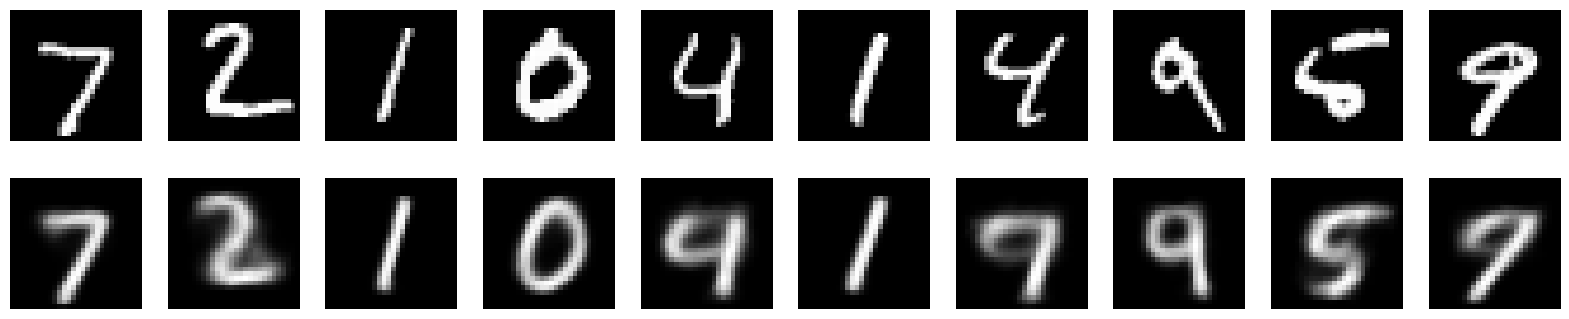

In [4]:
# Paramètres
latent_dim = 2  # Dimension de l'espace latent
batch_size = 128
epochs = 20
learning_rate = 1e-3

# Définition du modèle
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        std = torch.exp(0.5 * z_log_var)
        epsilon = torch.randn_like(std)
        return z_mean + epsilon * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, z_mean, z_log_var

# Perte pour le VAE
def vae_loss(reconstructed, original, z_mean, z_log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction="sum")
    kl_divergence = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return reconstruction_loss + kl_divergence

# Initialisation du modèle, de l'optimiseur et du périphérique
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Entraînement
model.train()
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x = x.view(-1, 28 * 28)  # Flatten
        optimizer.zero_grad()
        reconstructed, z_mean, z_log_var = model(x)
        loss = vae_loss(reconstructed, x, z_mean, z_log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

# Visualisation : reconstruction d'images
def plot_reconstruction():
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(test_loader))
        x = x.to(device)
        x = x.view(-1, 28 * 28)
        reconstructed, _, _ = model(x)
        x = x.view(-1, 28, 28).cpu()
        reconstructed = reconstructed.view(-1, 28, 28).cpu()
        
        n = 10  # Nombre d'images
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # Image originale
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(x[i], cmap="gray")
            plt.axis("off")

            # Image reconstruite
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed[i], cmap="gray")
            plt.axis("off")
        plt.show()

plot_reconstruction()

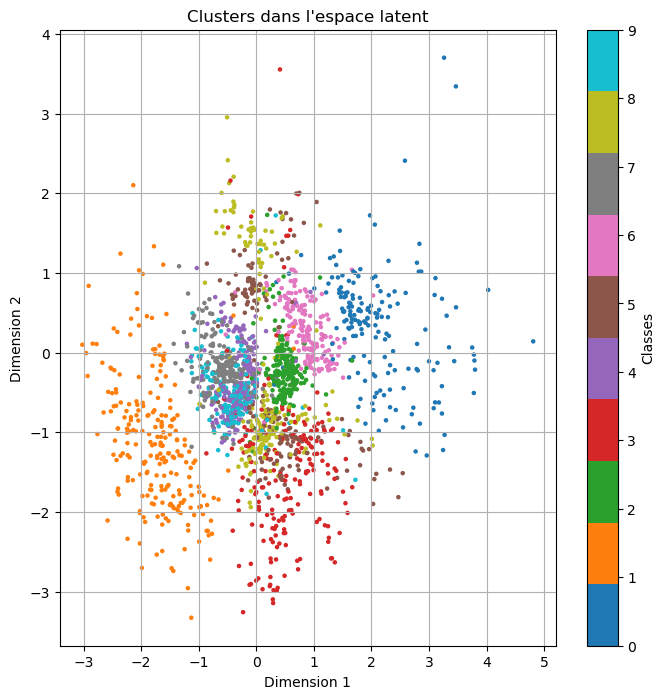

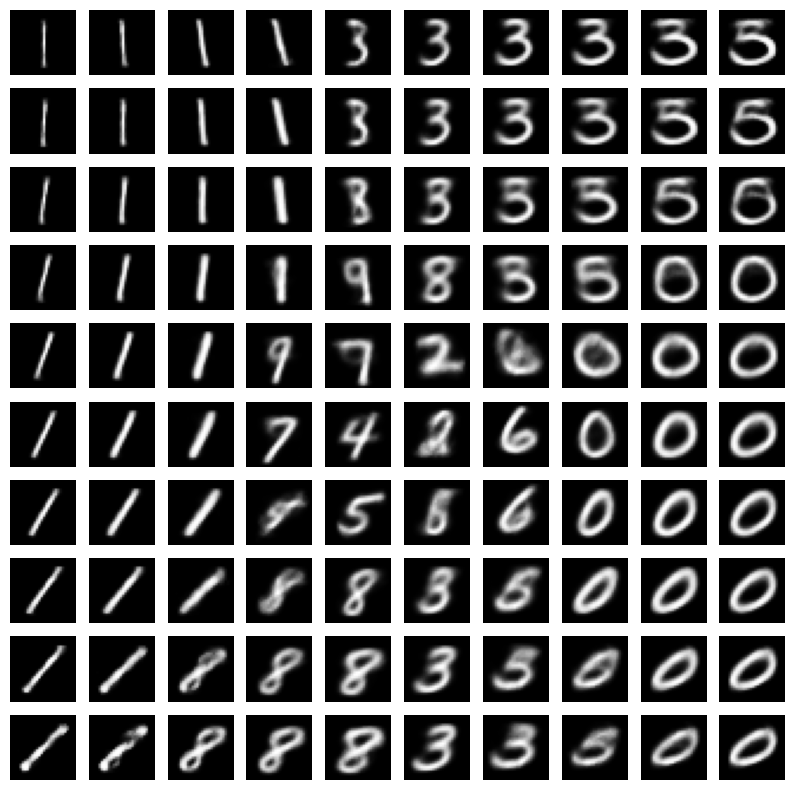

In [7]:
def construction_clusters(model, data_loader, num_points=2000):
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device).view(-1, 28 * 28)
            z_mean, _ = model.encode(x)  # On utilise z_mean pour observer la structure
            latents.append(z_mean.cpu().numpy())
            labels.append(y.numpy())
            if len(latents) * len(latents[0]) >= num_points:
                break
    
    latents = np.concatenate(latents)[:num_points]
    labels = np.concatenate(labels)[:num_points]

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap="tab10", s=5)
    plt.colorbar(scatter, label="Classes")
    plt.title("Clusters dans l'espace latent")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

# Générer des images à partir d'une grille dans l'espace latent
def generer_dataset(model, grid_size=10, latent_range=(-3, 3)):
    model.eval()
    latent_points = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid = np.array([[np.array([x, y]) for x in latent_points] for y in latent_points]).reshape(-1, 2)
    grid = torch.tensor(grid, dtype=torch.float32).to(device)

    with torch.no_grad():
        images_reconstruites = model.decode(grid).view(-1, 28, 28).cpu().numpy()

    # Visualisation des images générées
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images_reconstruites):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

    # Retourner le dataset généré
    return images_reconstruites

# Tracer les clusters dans l'espace latent
construction_clusters(model, test_loader, num_points=2000)

# Générer un dataset à partir de points dans l'espace latent
generated_dataset = generer_dataset(model, grid_size=10, latent_range=(-3, 3))

On peut utiliser la méthode t-SNE, qui consiste à définir une distribution de probabilités sur les paires de points de telle façon que les points les plus proches ont une meilleure chance d'être choisie. Il s'agit donc de minimiser la divergence de Kullback-Leibler pour minimiser les écarts entre les points.

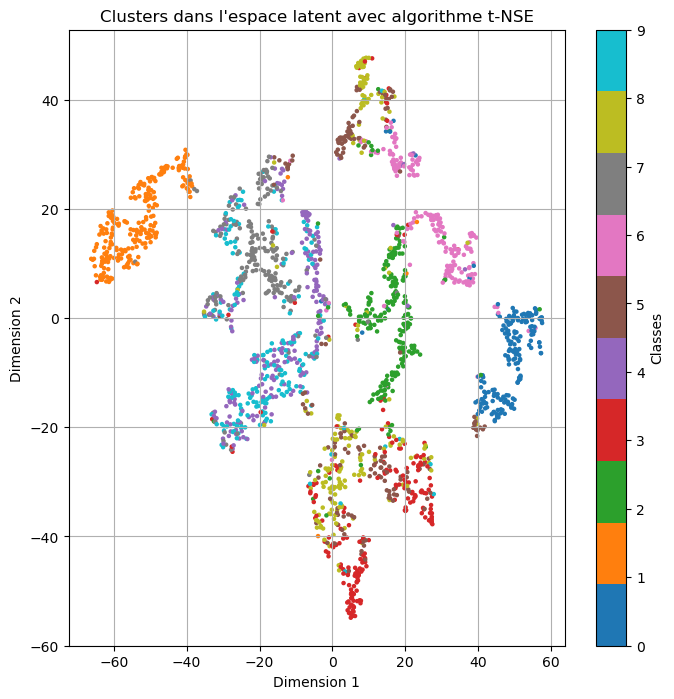

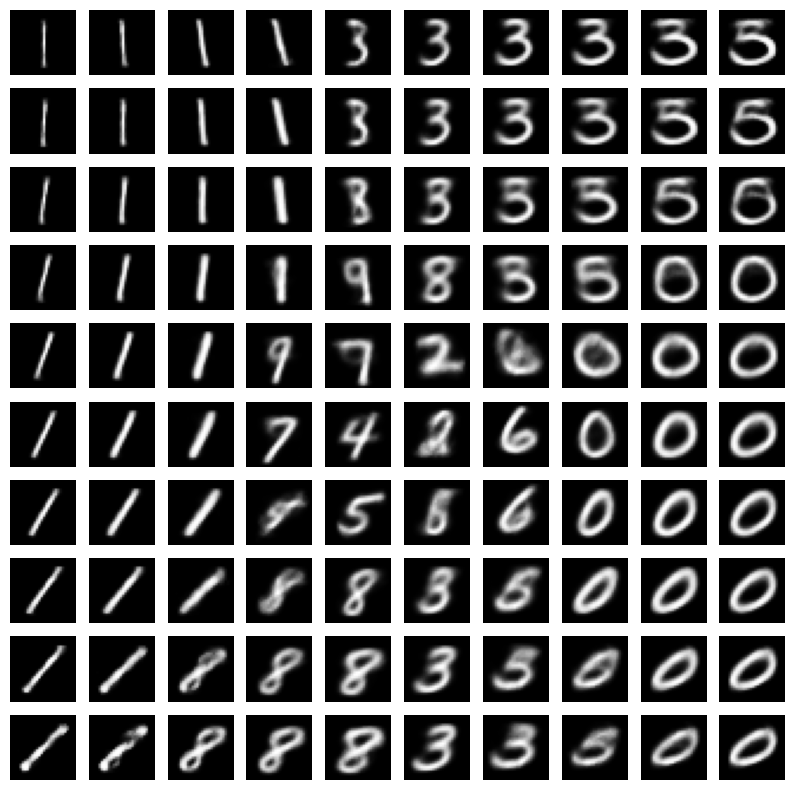

In [11]:
from sklearn.manifold import TSNE

# Tracer les clusters dans l'espace latent
def construction_clusters(model, data_loader, num_points=1000):
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device).view(-1, 28 * 28)
            z_mean, z_log_var = model.encode(x)
            z = model.reparameterize(z_mean, z_log_var)
            latents.append(z.cpu().numpy())
            labels.append(y.numpy())
            if len(latents) * len(latents[0]) >= num_points:
                break
    
    latents = np.concatenate(latents)[:num_points]
    labels = np.concatenate(labels)[:num_points]

    # Réduction de dimension (PCA ou t-SNE)
    reduced_latents = TSNE(n_components=2, random_state=42).fit_transform(latents)
    
    # Tracé des clusters
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=labels, cmap="tab10", s=5)
    plt.colorbar(scatter, label="Classes")
    plt.title(f"Clusters dans l'espace latent avec algorithme t-NSE")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

# Générer des images à partir de points dans l'espace latent
def generer_dataset(model, grid_size=10, latent_range=(-3, 3)):
    model.eval()
    latent_points = np.linspace(latent_range[0], latent_range[1], grid_size)
    grid = np.array([[np.array([x, y]) for x in latent_points] for y in latent_points]).reshape(-1, 2)
    grid = torch.tensor(grid, dtype=torch.float32).to(device)

    with torch.no_grad():
        images_reconstruites = model.decode(grid).view(-1, 28, 28).cpu().numpy()

    # Visualisation des images générées
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images_reconstruites):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

    # Retourner le dataset généré
    return images_reconstruites

# Tracer les clusters dans l'espace latent
construction_clusters(model, test_loader, num_points=2000)

# Générer un dataset à partir de points dans l'espace latent
generated_dataset = generer_dataset(model, grid_size=10, latent_range=(-3, 3))
